In [4]:
import torch
import numpy as np
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference.base import prepare_for_sbi, simulate_for_sbi
from sbi.inference.snpe.snpe_c import SNPE_C as SNPE
from sbi.inference.snle.snle_a import SNLE_A as SNLE
from sbi.inference.snre.snre_b import SNRE_B as SNRE
from cost_aware_snle_a import CostAwareSNLE_A
from sbi.inference.abc.smcabc import SMCABC
from sbi.utils.get_nn_models import posterior_nn
from sbi.utils import BoxUniform
from sbi.utils import process_prior

from simulators.turin import Turin


import utils as u

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import time

import matplotlib
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def TurinModel(theta, B = 4e9, Ns = 801, N = 50, tau0 = 0, output = "moments"):

    G0 = theta[0].to(device)
    T = theta[1].to(device)
    lambda_0 = theta[2].to(device)
    sigma2_N = theta[3].to(device)
    
    nRx = N

    delta_f = B / (Ns - 1)  # Frequency step size
    t_max = 1 / delta_f

    tau = torch.linspace(0, t_max, Ns)

    H = torch.zeros((nRx, Ns), dtype=torch.cfloat)
    mu_poisson = lambda_0 * t_max  # Mean of Poisson process

    for jR in range(nRx):

        n_points = int(torch.poisson(mu_poisson))  # Number of delay points sampled from Poisson process

        delays = (torch.rand(n_points) * t_max).to(device)  # Delays sampled from a 1-dimensional Poisson point process

        delays = torch.sort(delays)[0]

        alpha = torch.zeros(n_points,
                            dtype=torch.cfloat).to(device)  # Initialising vector of gains of length equal to the number of delay points

        sigma2 = G0 * torch.exp(-delays / T) / lambda_0 * B

        for l in range(n_points):
            if delays[l] < tau0:
                alpha[l] = 0
            else:
                std = torch.sqrt(sigma2[l] / 2)
                alpha[l] = torch.normal(0, std) + torch.normal(0, std) * 1j

        H[jR, :] = torch.matmul(torch.exp(-1j * 2 * torch.pi * delta_f * (torch.ger(torch.arange(Ns), delays))), alpha)

    # Noise power by setting SNR
    Noise = torch.zeros((nRx, Ns), dtype=torch.cfloat).to(device)

    for j in range(nRx):
        normal = torch.distributions.normal.Normal(0, torch.sqrt(sigma2_N / 2))
        Noise[j, :] = normal.sample([Ns]) + normal.sample([Ns]) * 1j

    # Received signal in frequency domain

    Y = H + Noise
    
    if output=="moments":
        temporal_moments = temporalMomentsGeneral(Y)
        return temporal_moments
    elif output == "data":    
        y = torch.zeros(Y.shape, dtype=torch.cfloat).to(device)
        p = torch.zeros(Y.shape).to(device).to(device)
        lens = len(Y[:, 0])

        for i in range(lens):
            y[i, :] = torch.fft.ifft(Y[i, :])

            p[i, :] = torch.abs(y[i, :]) ** 2

        return 10 * torch.log10(p)

def temporalMomentsGeneral(Y, K=3, B=4e9):
    N, Ns = Y.shape
    
    delta_f = B / (Ns-1)
    t_max = 1 / delta_f

    tau = torch.linspace(0, t_max, Ns)
    out = torch.zeros((N, K), dtype=torch.float64)
        
    for k in range(K):
        for i in range(N):
            y = torch.fft.ifft(Y[i, :])
            out[i, k] = torch.trapz(tau**(k) * (torch.abs(y)**2), tau)
    
    x_stat = torch.zeros((6,))
    x_stat[0:3] = torch.mean(torch.log(out), axis = 0)
    x_stat[3:6] = torch.std(torch.log(out), axis = 0)
    
    return x_stat

## 1. Computational cost vs arrival rate

In [12]:
n_rep = 5
num_dim = 4
n_steps = 6

theta = torch.ones(n_steps, num_dim)

theta[:,0] = theta[:,0] * 5e-8
theta[:,1] = theta[:,1] * 5e-8
theta[:,3] = theta[:,3] * 5e-9
theta[:,2] = torch.tensor([1e9, 2e9, 4e9, 6e9, 8e9, 1e10])

elapsed_time = torch.zeros(n_steps)

for i in range(n_steps):
    st = time.time()
    
    for j in range(n_rep):
        y = TurinModel(theta[i, :])
        
    et = time.time()
    elapsed_time[i] = (et - st)/n_rep

In [13]:
alpha = (elapsed_time[n_steps-1] - elapsed_time[0]) / (theta[n_steps-1, 2] - theta[0, 2]) 
beta = -alpha * theta[0, 2] + elapsed_time[0]

np.save("turin_cost_alpha", alpha)
np.save("turin_cost_beta", beta)

In [3]:
def cost_linear(theta, alpha, beta):
    return alpha * theta + beta

In [ ]:
plt.figure(figsize=(3, 3))

plt.scatter(theta[:,2], elapsed_time, marker = "o", color = "C0", s = 60, alpha = 0.8)
plt.ylabel('Cost [seconds]', fontsize = 16)
plt.xlabel('$\\theta_3$: Arrival rate', fontsize = 16)
#plt.savefig("figures/plot_cost_turin.pdf", bbox_inches='tight', dpi = 300, format="pdf")
plt.show()

In [4]:
alpha = np.load("turin_cost_alpha.npy")
beta = np.load("turin_cost_beta.npy")

print((alpha * 1e9 + beta)**2)
print((alpha * 1e10 + beta)**2)

1.7279028898602176
139.18434621286718


# 2. Generating data for NLE

In [19]:
num_dim = 4
prior_start = torch.tensor([1e-9, 1e-9, 1e9, 1e-10])
prior_end = torch.tensor([1e-8, 1e-8, 1e10, 1e-9])

prior = utils.BoxUniform(low=prior_start * torch.ones(num_dim), high=prior_end * torch.ones(num_dim))

In [4]:
num_sim = 10000

x_turin_npe = torch.zeros(size = (num_sim, 6))

st = time.time()

prior_samples = prior.sample((num_sim,))

for i in range(num_sim):
    x_turin_npe[i,:] = TurinModel(prior_samples[i,:])
    
    if i%1000==0:
        print(i)
        
et = time.time()

np.save("turin_time_nle", et-st)
np.save("turin_theta_nle", prior_samples)
np.save("turin_x_nle", x_turin_npe)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [36]:
# generating observed data

theta_true = torch.tensor([4e-9, 7e-9, 5e9, 3e-10])
x_obs = TurinModel(theta_true, N = 500)

In [69]:
np.save("turin_x_obs", x_obs)

# Generating data using cost-aware proposal

In [66]:
num_sim = 10000
k = 2

x_turin_ca = torch.zeros(size = (num_sim, 6))
theta_tilde = torch.zeros(num_sim, num_dim)

count = 0

st = time.time()

while count < num_sim:
    param_value = prior.sample()
    if u.A_theta_Gamma(param_value[2], k, alpha = alpha, beta=beta, prior_start=prior_start[2]) > torch.rand(1):
        theta_tilde[count, :] = param_value
        count += 1
        
for i in range(num_sim):
    x_turin_ca[i,:] = TurinModel(theta_tilde[i,:])
    
    if i%1000==0:
        print(i)
        
et = time.time()

np.save("turin_time_ca_nle_k2", et-st)
np.save("turin_theta_ca_nle_k2", theta_tilde)
np.save("turin_x_ca_nle_k2", x_turin_ca)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


## Mixture proposal

In [78]:
num_sim = 10000
k = np.array([0, 1, 2, 3]) # Exponent of the penaly function g(z) = z^k

num_mixtures = k.size
num_per_mixture = int(round(num_sim / num_mixtures))

x_turin_ca = torch.zeros(size = (num_sim, 6))
theta_tilde = torch.zeros(num_sim, num_dim)
w_u = torch.zeros(num_sim,)

count = 0

st = time.time()

for ind in range(k.size):

    while count < ((ind + 1)*num_per_mixture):
        param_value = prior.sample()
        if u.A_theta_Gamma(param_value[2], k[ind], alpha = alpha, beta=beta, prior_start=prior_start[2]) > torch.rand(1):
            theta_tilde[count, :] = param_value
            w_u[count] = u.cost_linear(theta_tilde[count,2], alpha, beta)**k[ind]    #self-normalised importance weights
            count += 1
        
for i in range(num_sim):
    x_turin_ca[i,:] = TurinModel(theta_tilde[i,:])
    
    if i%1000==0:
        print(i)
        
et = time.time()

np.save("turin_time_ca_nle_mixture", et-st)
np.save("turin_theta_ca_nle_mixture", theta_tilde)
np.save("turin_x_ca_nle_mixture", x_turin_ca)
np.save("turin_weights_mixture", w_u)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


## CG $\times$ ESS

In [68]:
num_sim = 20000
num_repeats = 1
k = np.array([0, 0.5, 1, 2, 3]) # Exponent of the penaly function g(z) = z^k

ess_cost_aware = np.zeros(shape = (k.size, num_repeats))
ceg = np.zeros(shape = (k.size, num_repeats))

for ind in range(k.size):
    for j in range(num_repeats):
        
        if ind == 0:

            theta = prior.sample((num_sim,))

            ess_cost_aware[ind, j] = 1
            ceg[ind, j] = 1
        else:
            # Sampling from cost-modified prior
            theta_tilde = torch.zeros(num_sim, num_dim)
            count = 0

            while count < num_sim:
                param_value = prior.sample()
                if u.A_theta_Gamma(param_value[2], k[ind], alpha = alpha, beta=beta, prior_start=prior_start[2]) > torch.rand(1):
                    theta_tilde[count,:] = param_value
                    count += 1

            w_u = u.cost_linear(theta_tilde[:,2], alpha, beta)**k[ind]   #self-normalised importance weights
            
            # Compute CEG
            ceg[ind, j] = torch.mean(u.cost_linear(theta[:,2], alpha, beta)) / torch.mean(u.cost_linear(theta_tilde[:,2], alpha, beta))
            # Compute ESS
            ess_cost_aware[ind, j] = ((w_u.sum())**2 / torch.square(w_u).sum()) / num_sim
    print(ind)

0
1
2
3
4


In [64]:
# Define the prior
num_dims = 1
num_sims = 1000
num_rounds = 2
prior = BoxUniform(low=torch.zeros(num_dims), high=torch.ones(num_dims))
# simulator = lambda theta: theta + torch.randn_like(theta) * 0.1
x_o = torch.tensor([0.5, 0.5])

In [65]:
from sbi.inference import SNLE

inference = SNLE(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x).train()
#     posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
#                                           mcmc_parameters={"num_chains": 20,
#                                                            "thin": 5})
#     proposal = posterior.set_default_x(x_o)

 Neural network successfully converged after 83 epochs.

In [111]:
simulator, prior = prepare_for_sbi(TurinModel, prior)

# Instantiate the inference object
inference = SNPE(prior=prior, density_estimator="maf")

In [112]:
num_rounds = 1 # Number of rounds of SNPE
num_sim = 1000  # Number of simulations in each round

posteriors = []
proposal = prior

st = time.time()

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=num_sim)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(obs_data)
    
et = time.time()
print(print('Execution time:', et - st, 'seconds'))

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 195 epochs.Execution time: 10320.359754800797 seconds
None


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

(1.000000013351432e-10, 9.999999717180685e-10)

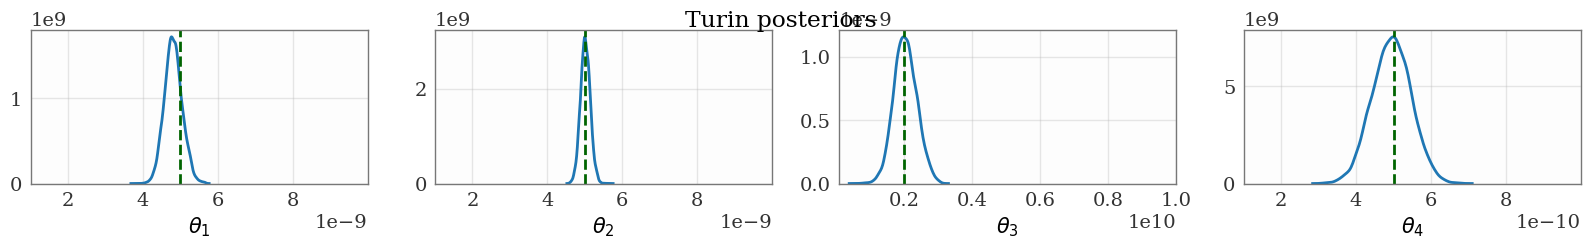

In [114]:
# Drawing samples from the posterior given the observed data
samples = posterior.sample((10000,), x=obs_data)

# Plotting posteriors
fig, axes = plt.subplots(1, num_dim, figsize=(20, 2))
fig.suptitle('Turin posteriors')

sns.kdeplot(samples[:,0], color = "C0", linewidth = 2, linestyle = "solid", label = "dim1", ax = axes[0])
axes[0].set_xlabel("$\\theta_1$", fontsize = 15)
axes[0].axvline(theta_true[0], color = "darkgreen", linestyle = "dashed", label = "$\\theta_0$")
axes[0].set_ylabel("")
axes[0].set_xlim(prior_start[0], prior_end[0])

sns.kdeplot(samples[:,1], color = "C0", linewidth = 2, linestyle = "solid", label = "dim1", ax = axes[1])
axes[1].set_xlabel("$\\theta_2$", fontsize = 15)
axes[1].axvline(theta_true[1], color = "darkgreen", linestyle = "dashed", label = "$\\theta_0$")
axes[1].set_ylabel("")
axes[1].set_xlim(prior_start[1], prior_end[1])

sns.kdeplot(samples[:,2], color = "C0", linewidth = 2, linestyle = "solid", label = "dim1", ax = axes[2])
axes[2].set_xlabel("$\\theta_3$", fontsize = 15)
axes[2].axvline(theta_true[2], color = "darkgreen", linestyle = "dashed", label = "$\\theta_0$")
axes[2].set_ylabel("")
axes[2].set_xlim(prior_start[2], prior_end[2])

sns.kdeplot(samples[:,3], color = "C0", linewidth = 2, linestyle = "solid", label = "dim1", ax = axes[3])
axes[3].set_xlabel("$\\theta_4$", fontsize = 15)
axes[3].axvline(theta_true[3], color = "darkgreen", linestyle = "dashed", label = "$\\theta_0$")
axes[3].set_ylabel("")
axes[3].set_xlim(prior_start[3], prior_end[3])

# NPE & NLE

In [5]:
turin = Turin()
prior = [[1e-9, 1e-8], [1e-9, 1e-8], [1e9, 1e10], [1e-10, 1e-9]]

In [6]:
i=4
checkpoint_path = f"sims/turin/2.0/npe/{i+1}/ckpt.tar"
checkpoint = torch.load(checkpoint_path, map_location='cpu')

posterior_npe = checkpoint["posterior_npe"]
posterior_canpe = checkpoint["posterior_canpe"]

posterior_samples_npe = checkpoint["posterior_samples_npe"]
posterior_samples_canpe = checkpoint["posterior_samples_canpe"]
i=0
checkpoint_path = f"sims/turin/mixture/npe/{i+1}/ckpt.tar"
checkpoint = torch.load(checkpoint_path, map_location='cpu')

posterior_samples_canpe_mix = checkpoint["posterior_samples_canpe"]

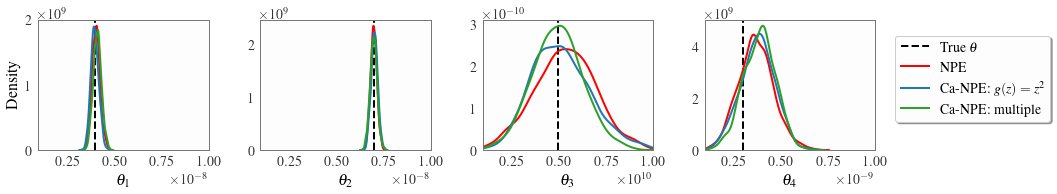

In [9]:
fig, axes = plt.subplots(1, 4, figsize=[15, 2.5])

for i, ax in enumerate(axes):
    ax.axvline(x=turin.theta_true[i], ls="--", c="black", label="True $\\theta$")
    sns.kdeplot(posterior_samples_npe[:, i], color="red", linewidth=2, linestyle="solid", label="NPE", ax=ax)
    sns.kdeplot(posterior_samples_canpe[:, i], color="C0", linewidth=2, linestyle="solid", label="Ca-NPE: $g(z)=z^2$", ax=ax)
    sns.kdeplot(posterior_samples_canpe_mix[:, i], color="C2", linewidth=2, linestyle="solid", label="Ca-NPE: multiple", ax=ax)
    
    ax.set_xlim(prior[i][0], prior[i][1])
    ax.set_xlabel(f"$\\theta_{i+1}$", size=16)

    if i == 0:
        ax.set_ylabel("Density", size=16)
    else:
        ax.set_ylabel("")

fig.subplots_adjust(top=0.85, hspace=0.3, wspace=0.3)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.99, 0.8), ncol=1, fontsize=14, fancybox=True, shadow=True)

plt.savefig("figures/plot_turin_npe.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
i=4
checkpoint_path = f"sims/turin/2.0/nle/{i+1}/ckpt.tar"
checkpoint = torch.load(checkpoint_path, map_location='cpu')

posterior_samples_nle = checkpoint["posterior_samples_npe"]
posterior_samples_canle = checkpoint["posterior_samples_canpe"]

checkpoint_path = f"sims/turin/mixture/npe/{i+1}/ckpt.tar"
checkpoint = torch.load(checkpoint_path, map_location='cpu')

posterior_samples_canle_mix = checkpoint["posterior_samples_canpe"]

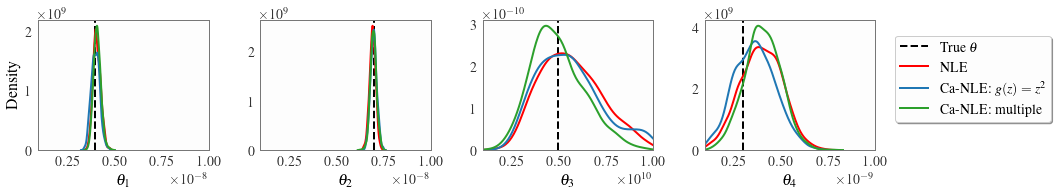

In [11]:
fig, axes = plt.subplots(1, 4, figsize=[15, 2.5])

for i, ax in enumerate(axes):
    ax.axvline(x=turin.theta_true[i], ls="--", c="black", label="True $\\theta$")
    sns.kdeplot(posterior_samples_nle[:, i], color="red", linewidth=2, linestyle="solid", label="NLE", ax=ax)
    sns.kdeplot(posterior_samples_canle[:, i], color="C0", linewidth=2, linestyle="solid", label="Ca-NLE: $g(z)=z^2$", ax=ax)
    sns.kdeplot(posterior_samples_canle_mix[:, i], color="C2", linewidth=2, linestyle="solid", label="Ca-NLE: multiple", ax=ax)
    
    ax.set_xlim(prior[i][0], prior[i][1])
    ax.set_xlabel(f"$\\theta_{i+1}$", size=16)

    if i == 0:
        ax.set_ylabel("Density", size=16)
    else:
        ax.set_ylabel("")

fig.subplots_adjust(top=0.85, hspace=0.3, wspace=0.3)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.99, 0.8), ncol=1, fontsize=14, fancybox=True, shadow=True)
plt.savefig("figures/plot_turin_nle.pdf", dpi=300, bbox_inches='tight')
plt.show()